In [2]:
import pandas as pd, numpy as np, numpy.linalg as nl, inspect, seaborn as sns, plotly, plotly.express as px, pickle, plotly.graph_objects as go, itertools
from tqdm import tqdm
from matplotlib.pyplot import *
from pathlib import Path
from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
import kneed
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report,precision_recall_fscore_support, normalized_mutual_info_score,confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, ward,single,complete
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from pandas.api.types import is_numeric_dtype

In [3]:
out_dir = Path('output')
res_dir = Path('results')
data_dir = Path('Data')
save = True
train_model = False
STATE = 1
cluster_anl = False
train_agg = True
agg_out_dir = Path('agg_output')

In [4]:
metadata = pd.read_csv(Path(data_dir,'train_data.csv'),header=None,names=['class','filename'])
metadata[['make','model','year']] = metadata['class'].str.split('_',expand=True)
features = pd.read_csv(Path(data_dir,'train_features.csv'),header=None)

In [5]:
def PCA_parameter_search(normalizers, data, func=PCA(), plotting=False, out_dir=res_dir, save=False):
    res = []
    for key in normalizers.keys():
        transformed = normalizers[key].fit_transform(data)
        func.fit(transformed)
        xs = np.arange(func.explained_variance_.shape[0])
        variance_agg = func.explained_variance_ratio_.cumsum()
        interval_95 = np.argwhere(variance_agg>.95)[0][0]
        interval_elbow = kneed.KneeLocator(xs,variance_agg,curve='concave',direction='increasing').elbow
        res.append([key, interval_95,interval_elbow])
        if plotting:
            fig = plot(xs,variance_agg, label='Aggregate PCA Variance')
            axvline(x=[interval_elbow],color='r',ls='--',label=f'Elbow Point={interval_elbow}')
            axvline(x=[interval_95],color='r',ls='--',label=f'95 Variance={interval_95}')
            xlabel('Number Components')
            ylabel('variance_ratio')
            title(f'{key}-scaled PCA')
            tight_layout()
            legend()
            if save:
                savefig(Path(out_dir,f'{key}_PCA_choice.png'))
            show()
    res = pd.DataFrame(columns = ['method','95_interval','elbow'], data=res)
    if save:
        res.to_csv(Path(out_dir,'Normalize_PCA_choices.csv'),index=False)
    return res

def load_model(model,loc=out_dir):
    filname = list(Path(loc).rglob('*'+model+'*'))
    if len(filname) == 0:
        raise ValueError("Can't find the file!")
    if len(filname) >1:
        raise ValueError("Located too many items matching that search. Please try again. We found: {}".format(filname))
    filname = filname[0]
    with open(filname,'rb') as fil:
        temp = pickle.load(fil)
    return temp

def seaborn_friendly(res,item='score'):
    res[f'mean_{item}'] = res[[f'mean_train_{item}',f'mean_test_{item}']].values.tolist()
    res['type'] = [['train','test']]*res.shape[0]
    res[f'std_{item}'] = res[[f'std_train_{item}',f'std_test_{item}']].values.tolist()
    res = res.explode([f'mean_{item}','type',f'std_{item}'],ignore_index=True)
    return res



In [6]:
normalizers = {'Standard':StandardScaler(), 'MinMax':MinMaxScaler()}
# data = features.values
# key, norm = 'Standard', normalizers['Standard']
# func = PCA()

In [7]:
# pca_cutoffs = PCA_parameter_search(normalizers,features.values,plotting=True,out_dir=res_dir, save=save)
# pca_cutoffs

In [8]:
# Adjust these values for experiments of different sizes.
train_percentage = .8
dataset_percentage=1

x_train, x_test, y_train, y_test =  train_test_split(features.values,metadata['class'].values,train_size=train_percentage*dataset_percentage, test_size=(1-train_percentage)*dataset_percentage)
# else:
#     x_train = features.values
#     y_train = metadata['class'].values
#'roc_weighted':roc_auc_score(average='weighted'),
scoring_items = ['accuracy','f1_weighted','roc_auc_ovr']#{'accuracy':accuracy_score,'roc_macro':roc_auc_score,'f1_weighted':f1_score(average='weighted')}
n_transform = [200, 250,300]

In [9]:
if train_model:
    #See if I can get tqdm working for this.
    svm_grids = {
            #'clf__kernel':['rbf','sigmoid'],
            'clf__gamma':np.linspace(0,.6,15)[1:],
            'clf__C':np.linspace(.25,1.25,10),
            'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None],
            'pca':[PCA(n_components=.95),None]
            #'scaler':list(normalizers.values()),
            #'pca__n_components':[.9, .95,.99]
        }
    #, max_iter=500
    svm_pipe = Pipeline([('Kmean',KMeans()),('pca',PCA(n_components = .95)),('scaler',MinMaxScaler()),('clf',SVC(kernel='rbf',probability=True))])
    svm_cv = GridSearchCV(svm_pipe, svm_grids, n_jobs=-1, verbose=10, cv=4, return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr',error_score='raise')
    svm_cv.fit(x_train, y_train)
    with open(Path(out_dir, 'svm_cv.pkl'),'wb') as fil:
        pickle.dump(svm_cv,fil)
    del svm_cv
    del svm_pipe
    






In [10]:
if train_model:
    mlp_grid = {
            'clf__hidden_layer_sizes' : [[128,128,64,64],[256,128,256,128,64],[256,128,64,64]],
            'clf__alpha': np.linspace(.2,.4,6),
            'clf__learning_rate_init':np.linspace(0,.02,6)[1:],
            'pca':[PCA(n_components=.95),None],
            'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None]
            #'scaler':list(normalizers.values()),
            #'pca__n_components':np.linspace(.9,.99,11)
        }
    mlp_pipe = Pipeline([('Kmean',KMeans()),('pca',PCA(n_components=.9)),('scaler',MinMaxScaler()),('clf',MLPClassifier())])
    mlp_cv = GridSearchCV(mlp_pipe, mlp_grid, n_jobs=-1, verbose=10, cv=4, return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr',error_score='raise')
    mlp_cv.fit(x_train, y_train)
    with open(Path(out_dir, 'mlp_cv.pkl'),'wb') as fil:
        pickle.dump(mlp_cv,fil)
    del mlp_cv
    del mlp_pipe

In [11]:
if train_model:
    # alphas = np.linspace(0.01, 5, 100) # Set to be more later tonight (was 51)
    nb_grid = {'scaler':list(normalizers.values())+[None],
            #'pca__n_components':np.linspace(.5,.99,50),
            'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None],
            'pca':[PCA(.95),None]
            }
    nb_pipe = Pipeline([('Kmean',KMeans()),  ('pca',PCA()),('scaler',MinMaxScaler()),('clf',GaussianNB())])
    nb_cv = GridSearchCV(nb_pipe, nb_grid, n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr',error_score='raise')
    nb_cv.fit(x_train,y_train)
    if save:
        with open(Path(out_dir,'nb_cv.pkl'),'wb') as fil:
            pickle.dump(nb_cv, fil)
    del(nb_cv)
    del(nb_pipe)

In [12]:
if train_model:
    estimators = np.arange(100, 500, 50) # Originally 100, 1000, 100
    max_depth = list(range(50,300, 50)) 
    #max_depth.append(None)
    max_features = ['sqrt','log2']
    rf_grid = { #'scaler':list(normalizers.values())+['passthrough'],
            #'pca__n_components':np.linspace(.85,.95,11),
            'clf__n_estimators':estimators, 'clf__max_depth':max_depth,# 'clf__max_features':max_features
            'pca':[PCA(n_components=.9),None],
            'Kmean':[KMeans(n_clusters=i) for i in n_transform]+[None]
        }
    rf_pipe = Pipeline([('Kmean',KMeans()), ('pca',PCA()), ('clf',RandomForestClassifier(max_features='sqrt'))])
    rf_cv = GridSearchCV(rf_pipe, rf_grid, n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr',error_score='raise')
    rf_cv.fit(x_train,y_train)
    if save:
        with open(Path(out_dir,'rf_cv.pkl'),'wb') as fil:
            pickle.dump(rf_cv, fil)
    del(rf_cv)
    del(rf_pipe)

In [15]:
if train_agg:
    models = [load_model(key, loc=out_dir).best_estimator_ for key in ['nb','mlp','svm','rf']]
    bag_grid = {
        'base_estimator':models,
        'n_estimators':[16,32,64],
        'max_samples': [.7,.8,.9,1],
        'max_features':[.7,.8,.9,1],
        'bootstrap': [True, False],
        'bootstrap_features':[True,False]
    }
    bag_model = BaggingClassifier(n_jobs=-1,random_state=STATE)
    bag_cv = GridSearchCV(bag_model,bag_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr',error_score='raise')
    bag_cv.fit(x_train,y_train)
    if save:
        with open(Path(agg_out_dir,'bag_cv.pkl'),'wb') as fil:
            pickle.dump(bag_cv, fil)
    del(bag_cv)
    del(bag_model)

Fitting 4 folds for each of 768 candidates, totalling 3072 fits
[CV 1/4; 1/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=0.7, n_estimators=16
[CV 2/4; 1/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=0.7, n_estimators=16
[CV 2/4; 2/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=0.7, n_estimators=32
[CV 4/4; 1/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=Tr

/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (

[CV 3/4; 7/768] END base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=0.9, n_estimators=16; accuracy: (train=0.794, test=0.695) f1_weighted: (train=0.798, test=0.703) roc_auc_ovr: (train=0.974, test=0.942) total time=  18.0s
[CV 2/4; 10/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=1, n_estimators=16


/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.s

[CV 3/4; 10/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=1, n_estimators=16


/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (

[CV 1/4; 7/768] END base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=0.9, n_estimators=16; accuracy: (train=0.786, test=0.718) f1_weighted: (train=0.792, test=0.724) roc_auc_ovr: (train=0.974, test=0.944) total time=  19.4s
[CV 4/4; 10/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=1, n_estimators=16


/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: invalid value encountered in subtract
  n_

[CV 4/4; 7/768] END base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=0.9, n_estimators=16; accuracy: (train=0.786, test=0.695) f1_weighted: (train=0.790, test=0.701) roc_auc_ovr: (train=0.974, test=0.949) total time=  18.6s
[CV 1/4; 11/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=1, n_estimators=32
[CV 2/4; 11/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=1, n_estimators=32
[CV 3/4; 11/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
    

/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (

[CV 4/4; 11/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=1, n_estimators=32


/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: divide by zero encountered in true_divide


[CV 1/4; 12/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=1, n_estimators=64


/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero enc

[CV 2/4; 12/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=1, n_estimators=64
[CV 3/4; 12/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=1, n_estimators=64


/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (

[CV 4/4; 12/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=1, n_estimators=64


/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:525: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S**2) / (

[CV 1/4; 13/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.8, max_samples=0.7, n_estimators=16


/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij =

[CV 2/4; 13/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.8, max_samples=0.7, n_estimators=16
[CV 3/4; 13/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.8, max_samples=0.7, n_estimators=16


/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:488: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/naive_bayes.py:487: RuntimeWarning: divide by zero enc

[CV 4/4; 13/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.8, max_samples=0.7, n_estimators=16
[CV 3/4; 3/768] END base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.7, max_samples=0.7, n_estimators=64; accuracy: (train=0.799, test=0.701) f1_weighted: (train=0.802, test=0.709) roc_auc_ovr: (train=0.979, test=0.945) total time=  47.8s
[CV 1/4; 14/768] START base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
                ('scaler', None), ('clf', GaussianNB())]), bootstrap=True, bootstrap_features=True, max_features=0.8, max_samples=0.7, n_estimators=32
[CV 1/4; 3/768] END base_estimator=Pipeline(steps=[('Kmean', None), ('pca', PCA(n_components=0.95)),
   

LinAlgError: SVD did not converge

In [ ]:

def plot_cv_param_res(res,xs, param, save=False, out_dir = '.',key='model', y='score'):
    test = seaborn_friendly(res,item=y)
    if isinstance(xs,str):
        xs = [xs] 
    for x in xs:
        try:
            ax = sns.lineplot(x=x, y=f'mean_{y}',hue=param,style='type',data=test.astype({param:str}))
        except:
            bootleg = []
            for item in test[x]:
                if item is not None:
                    bootleg.append(item.n_clusters)
                else:
                    bootleg.append('No Clustering')
            test['N Clusters'] = bootleg 
            hold = test[param].copy()
            test[param] = hold.astype(str) + ' Train'
            ax = sns.barplot(x='N Clusters', y=f'mean_{y}',hue=param,data=test.loc[test.type =='train'].astype({param:str,'N Clusters':str}))#,order=pd.unique(test[x]),hue_order=pd.unique(test[param]))
            test[param] = hold.astype(str) + ' Test'
            sns.barplot(x='N Clusters', y=f'mean_{y}',hue=param,data=test.loc[test.type =='test'].astype({param:str,'N Clusters':str}),palette='pastel')#,order=pd.unique(test[x]),hue_order=pd.unique(test[param]))
            test[param] = hold
        ax.set(title="{} {} by {}".format(key.upper(),y,param))
        if save:
            ax.get_figure().savefig(Path(out_dir,f"{param}_{y}_{x}.png"))
        show()


def analyze(key, x, test_x, test_y, save=False, out_dir='.', loc=out_dir):
    model_res = load_model(key,loc=loc)
    df =  pd.DataFrame.from_dict(model_res.cv_results_)
    scores = pd.unique(df.filter(regex='train_').columns.str.split('train_').str[1])
    if 'knn' in key:
        #Bootlegged solution to an annoying naming problem
        df.loc[~df['param_weights'].isin(['uniform','distance']),'param_weights'] = 'rbf'
    # if 'rf' in key:
    #     #Switch out the value with no limit of depth to be in line with the others, but slightly separated to notice it better.
    #     mask = df['param_max_depth'].isna()
    #     df.loc[mask,'param_max_depth'] = df.loc[~mask, 'param_max_depth'].max()+2*df.loc[~mask, 'param_max_depth'].diff().max()
    if 'mlp' in  key:
        df['param_clf__hidden_layer_sizes'] = df['param_clf__hidden_layer_sizes'].astype(str)
    ys = df.filter(regex='param').columns
    model_res_dir = Path(out_dir,key)
    if save:
        model_res_dir.mkdir(exist_ok=True)
    if isinstance(x,str):
        droppables = [x,'params']
    else:
        droppables = x + ['params']
        combos = [i for i in x if i != 'param_Kmean']
        for subset in itertools.combinations(combos,2):
            for score in scores:
                contour_continuous(df,subset[0],subset[1],score, key, save=save, out_dir=model_res_dir)
    print(ys)
    ys = ys.drop(droppables)
    for param in ys:
        for y in scores:
            plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key, y=y)
        #plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key,y='fit_time')
    best_res = handle_best(key, test_x, test_y, save=save, out_dir=model_res_dir)
    return df, best_res
    
def contour_continuous(df, x, y, score, item, save = False, out_dir='.'):
    title = f"{item} {score}: {x[6:]} vs. {y[6:]}"
    fig = go.Figure(data=go.Heatmap(z=df[f'mean_test_{score}'],x=df[x],y = df[y]))
    fig.data[0].update(zmin=0,zmax=1)
    fig.update_layout(title=title, xaxis_title=x, yaxis_title=y)
    if save:
        heatmap_dir = Path(out_dir,'heatmaps')
        heatmap_dir.mkdir(exist_ok=True)
        plotly.offline.plot(fig, filename=str(Path(heatmap_dir,f'{x}_{y}_{score}.html')),auto_open=False,image='png',image_filename=str(Path(heatmap_dir,f'{x}_{y}_{score}')))
    fig.show()

def handle_best(key, x_test, y_test, save=False, out_dir = out_dir):
    res = load_model(key)
    best_model = res.best_estimator_    
    df =  pd.DataFrame.from_dict(res.cv_results_)
    best_res = df.iloc[res.best_index_]
    le = LabelEncoder()
    le.fit(y_test)
    y_pred = best_model.predict_proba(x_test)
    best_res['best_final_test_accuracy'] = accuracy_score(le.transform(y_test),y_pred.argmax(axis=1))
    best_res['best_final_test_roc_ovr'] = roc_auc_score(pd.get_dummies(y_test),y_pred, multi_class='ovr')
    best_res['best_final_test_f1_weighted'] = f1_score(le.transform(y_test),y_pred.argmax(axis=1), average='weighted')

    best_res = best_res[best_res.index.drop(list(df.filter(regex='split')))]
    if save:
        print(out_dir)
        best_res.to_csv(Path(out_dir,'{}_best_results.csv'.format(key)))
        best_res.to_latex(Path(out_dir,'{}_best_results.tex'.format(key)))
    return best_res

def wrap_up(res_dir):
    df = pd.concat([pd.read_csv(i,index_col=0,names=[i.name.split('_')[0]],header=None) for i in res_dir.rglob("*best_results.csv")],axis=1).dropna()
    df.rename(index={df.index[0]:'Index'},inplace=True)
    df.to_csv(Path(res_dir,'all_best.csv'),float_format='%.4f')
    df.to_latex(Path(res_dir,'all_best.tex'),float_format='%.4f')

Index(['param_Kmean', 'param_pca', 'param_scaler', 'params'], dtype='object')


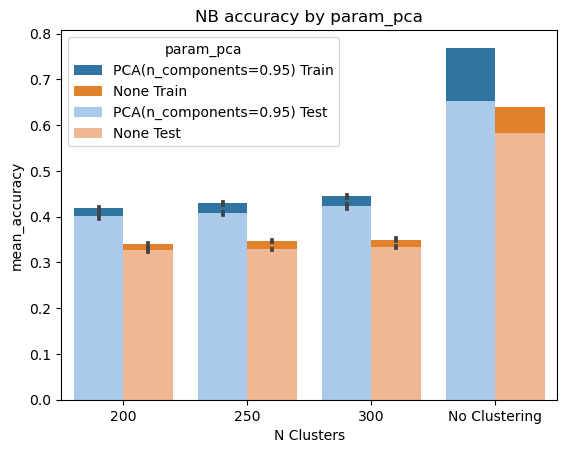

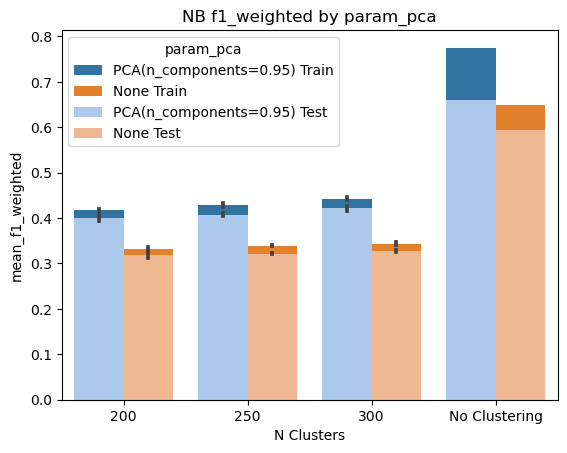

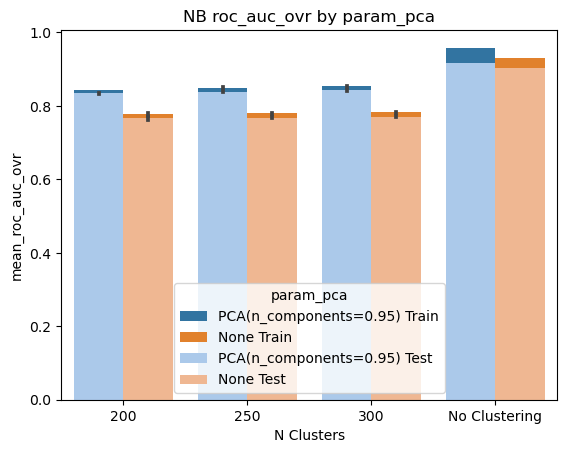

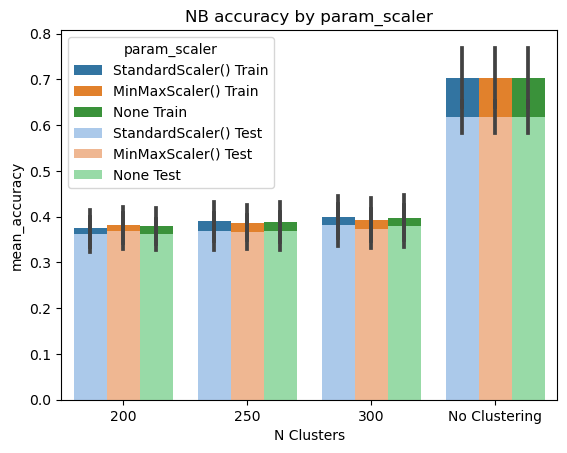

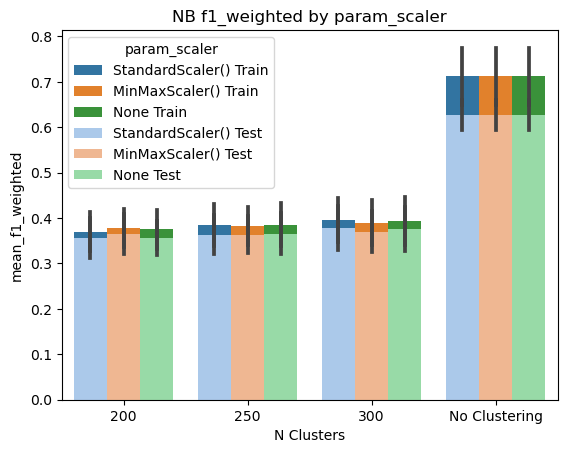

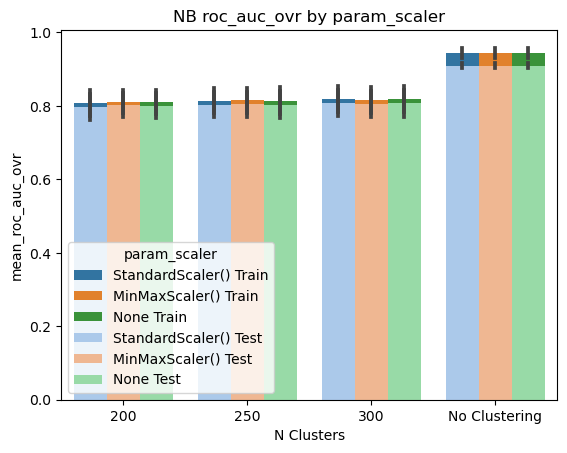

results/nb


/tmp/ipykernel_5715/3856954372.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

Index(['param_Kmean', 'param_clf__alpha', 'param_clf__hidden_layer_sizes',
       'param_clf__learning_rate_init', 'param_pca', 'params'],
      dtype='object')


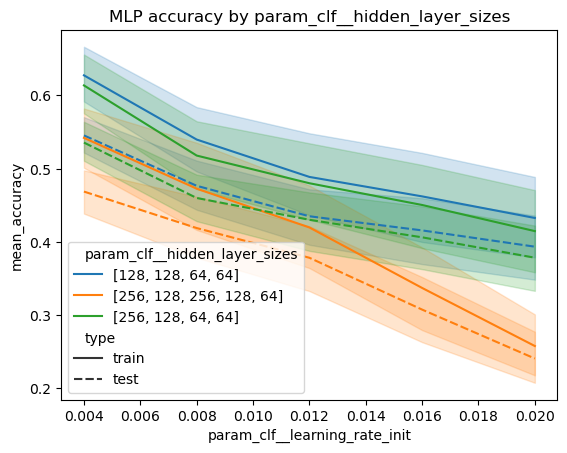

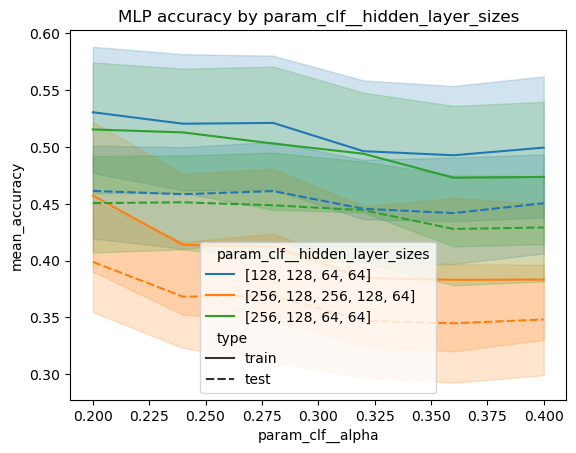

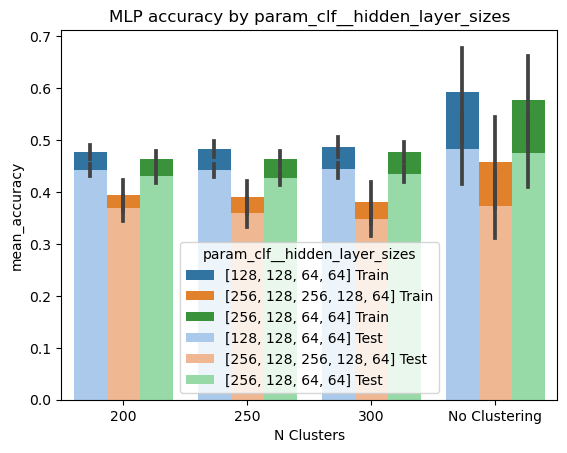

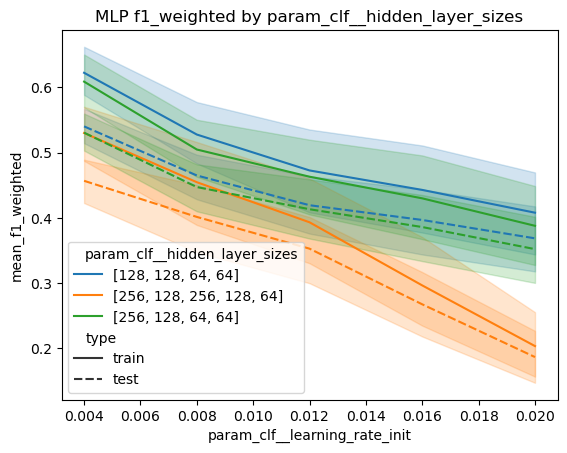

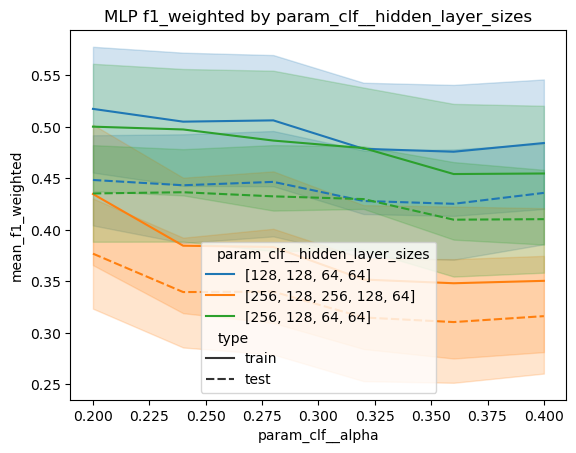

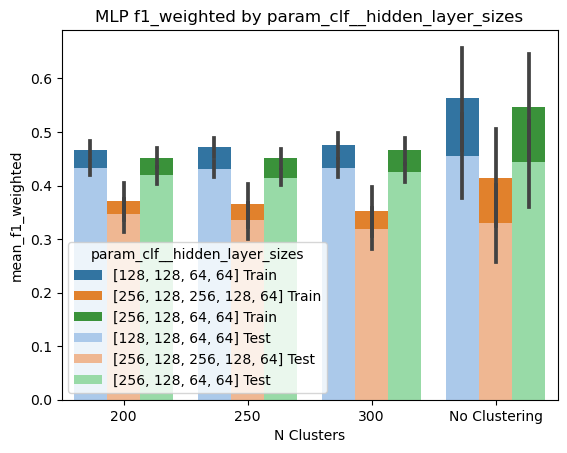

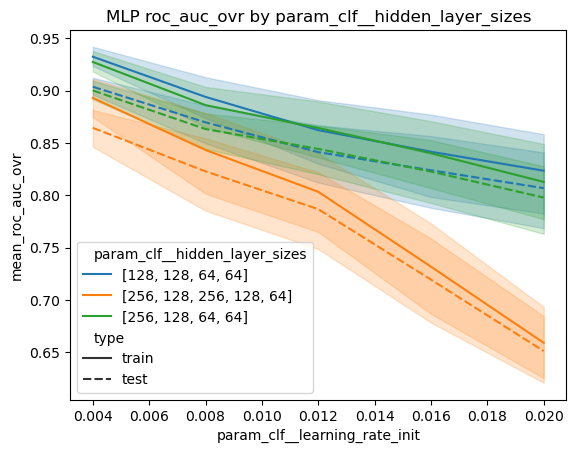

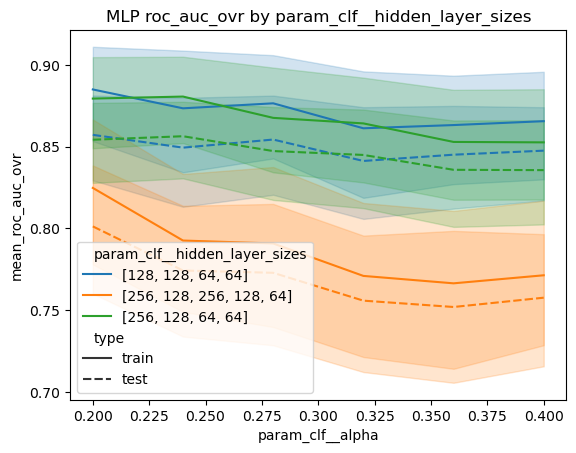

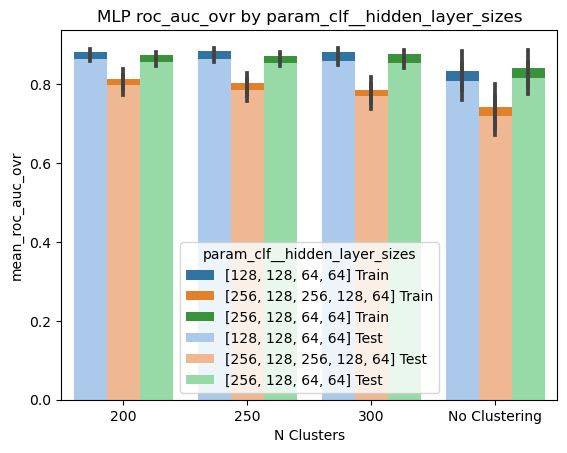

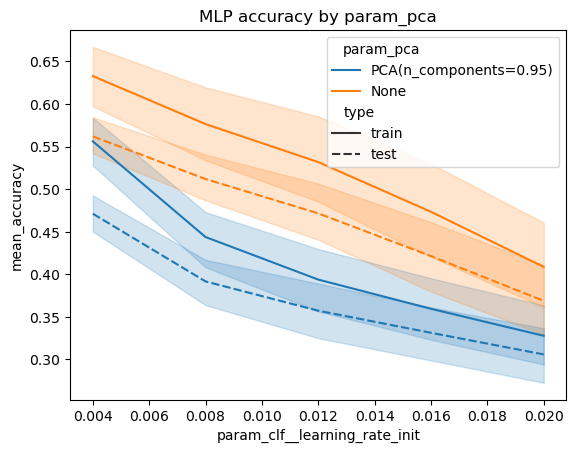

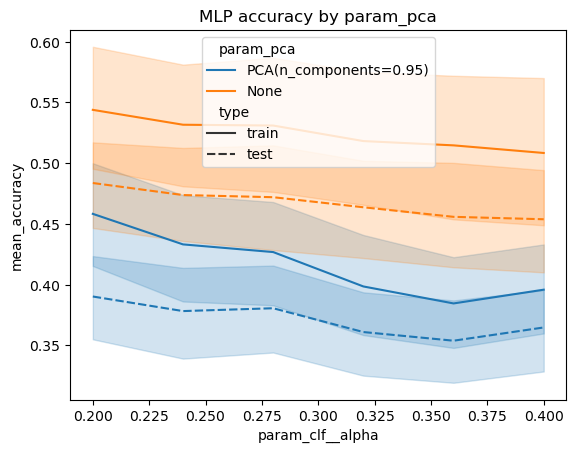

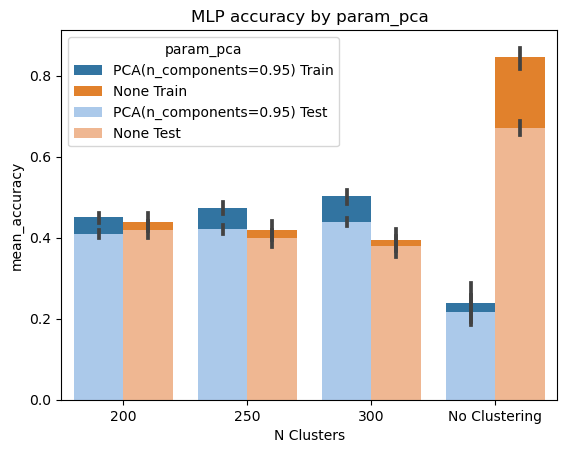

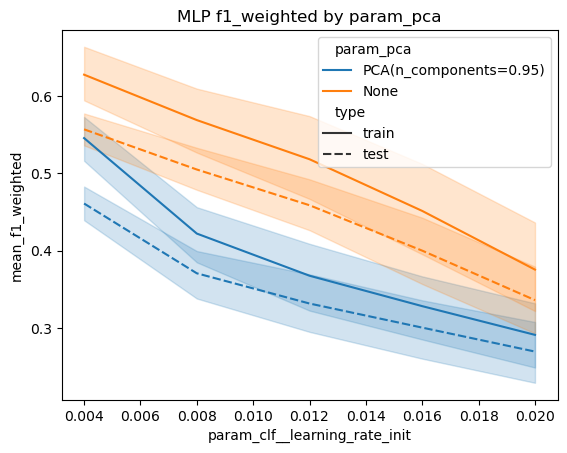

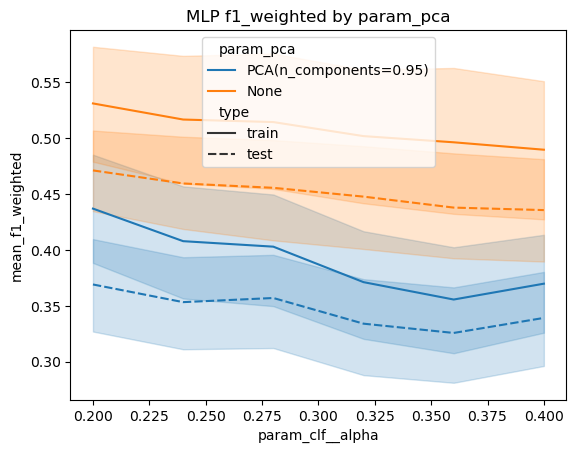

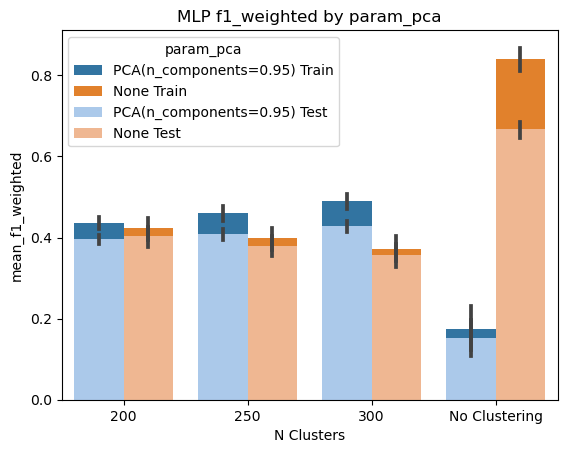

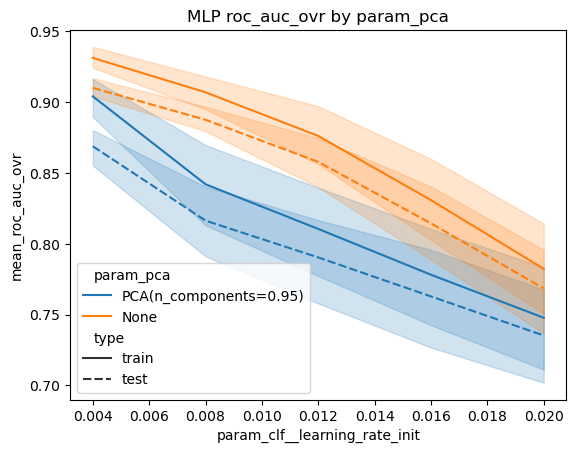

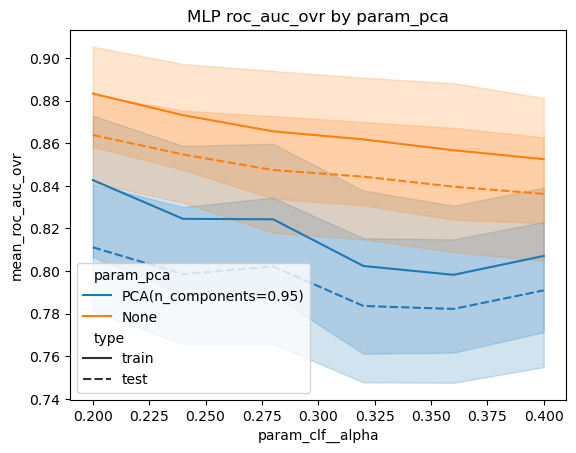

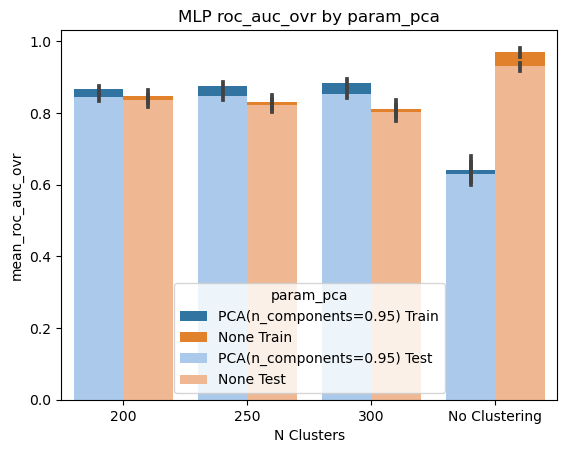

results/mlp


/tmp/ipykernel_5715/3856954372.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

Index(['param_Kmean', 'param_clf__C', 'param_clf__gamma', 'param_pca',
       'params'],
      dtype='object')


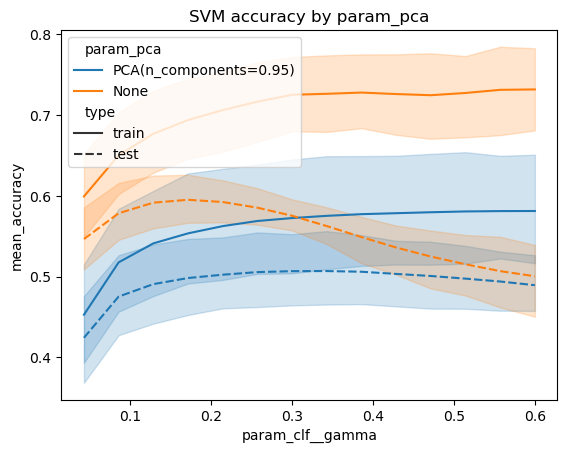

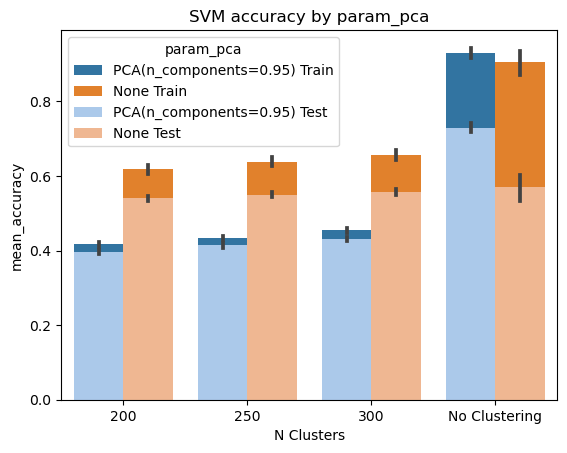

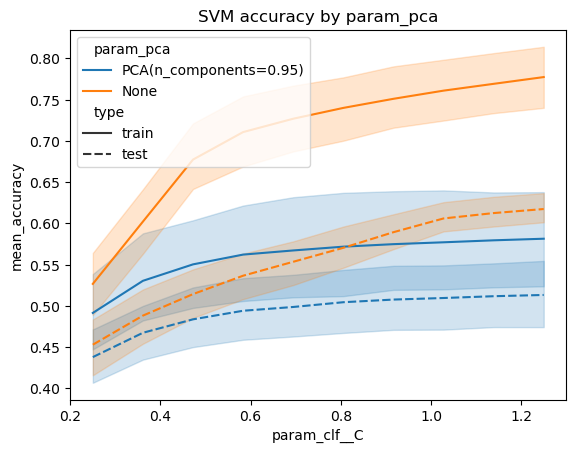

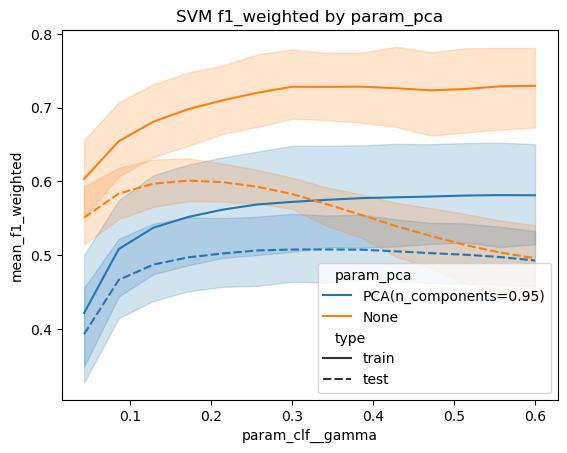

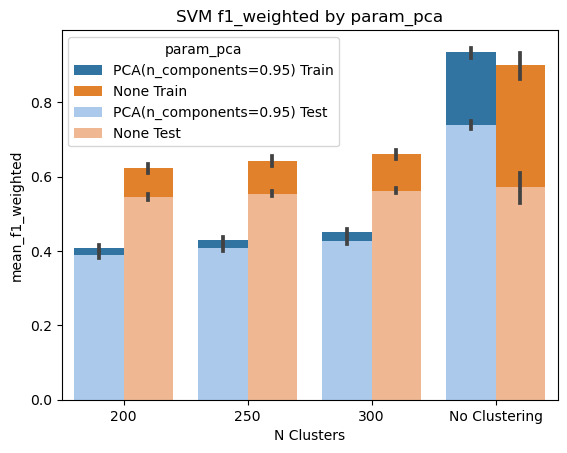

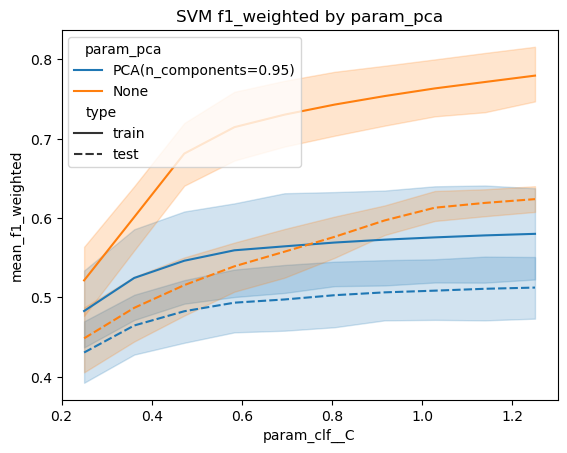

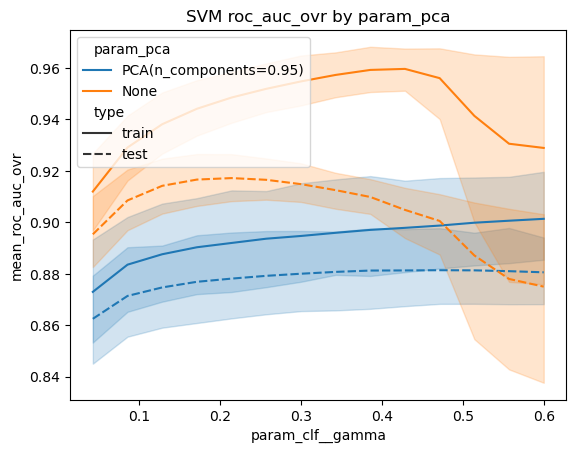

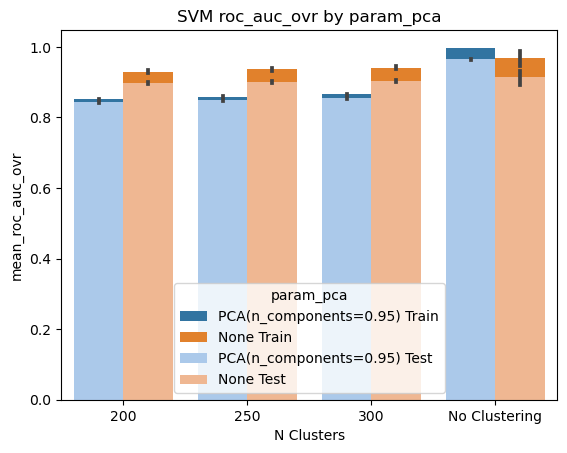

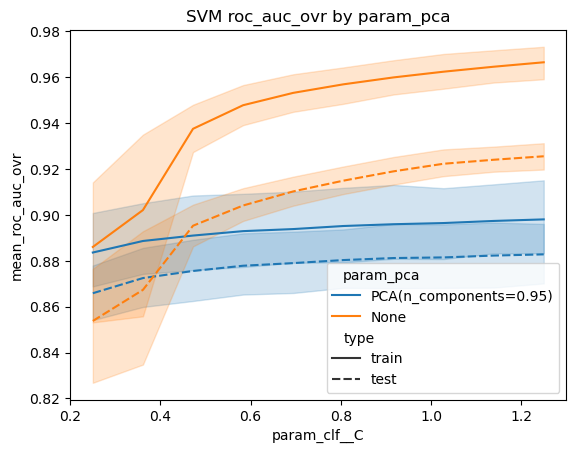

results/svm


/tmp/ipykernel_5715/3856954372.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

Index(['param_Kmean', 'param_clf__max_depth', 'param_clf__n_estimators',
       'param_pca', 'params'],
      dtype='object')


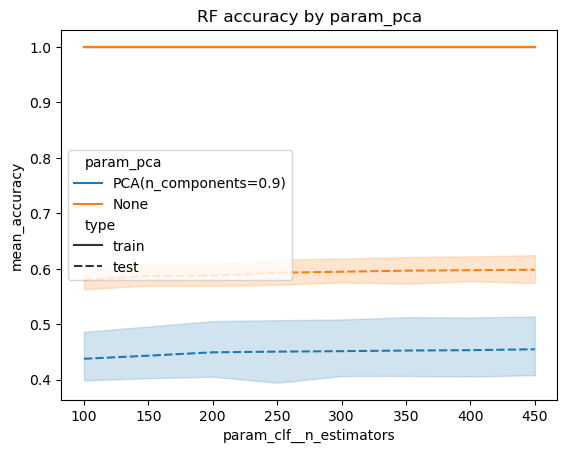

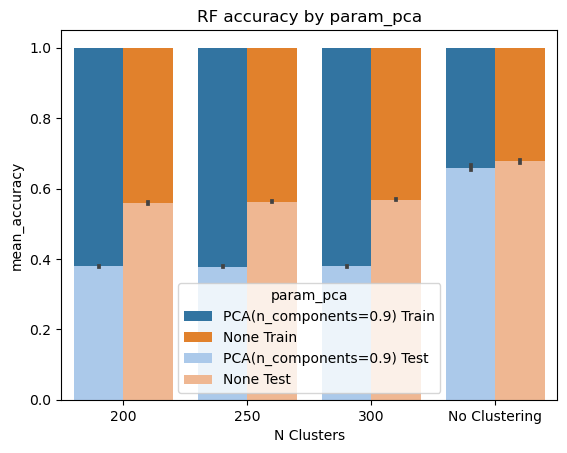

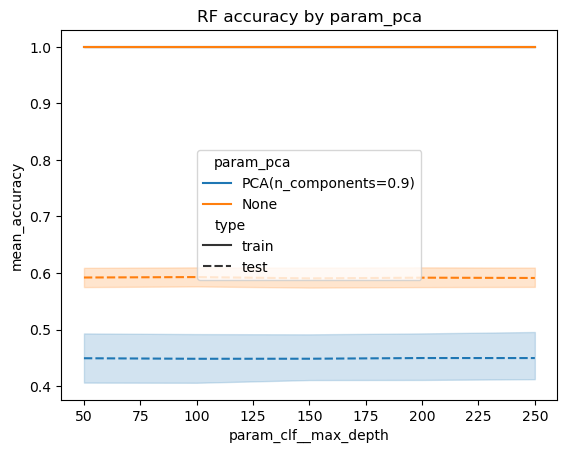

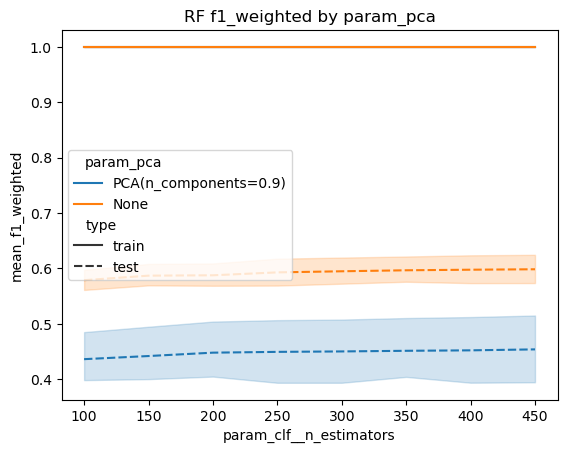

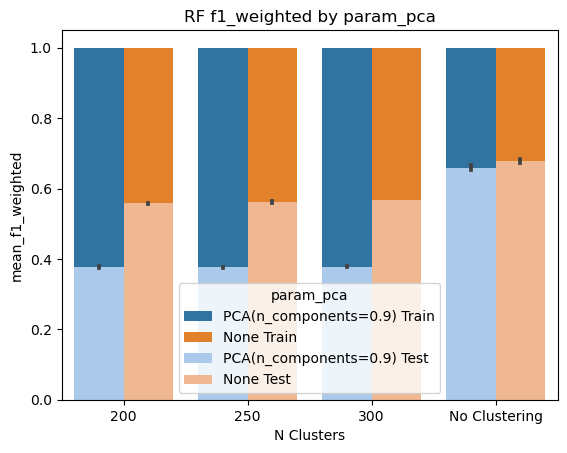

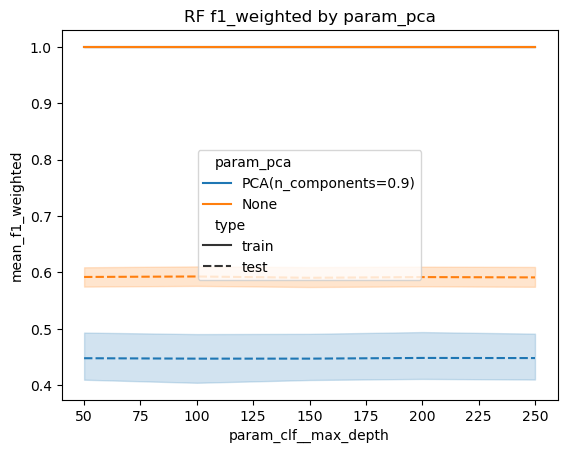

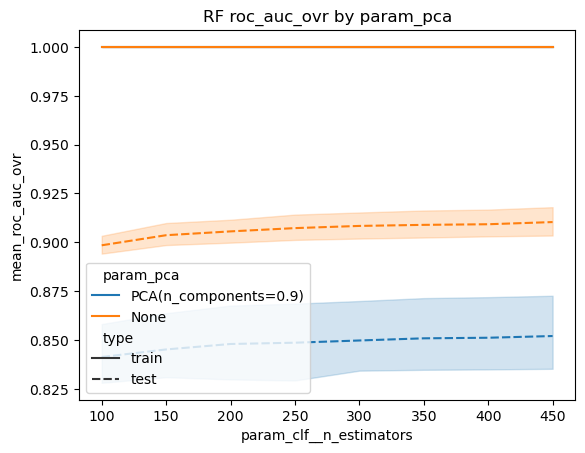

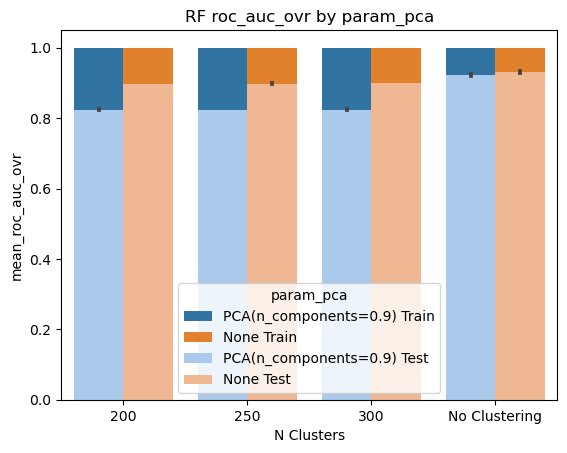

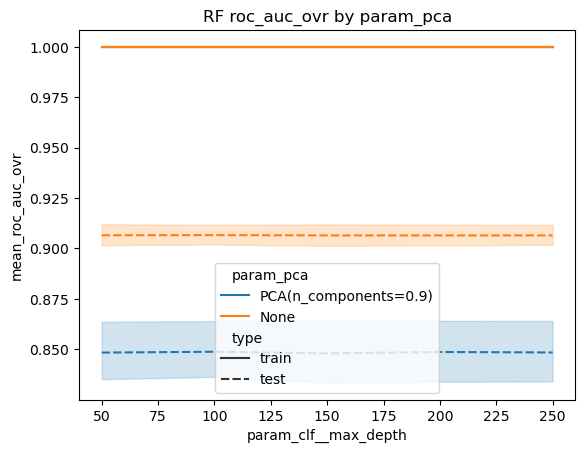

results/rf


/tmp/ipykernel_5715/3856954372.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5715/3856954372.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

In [ ]:
# keys = ['nb','mlp','svm','rf','bag']
# xs = ['param_Kmean',['param_clf__learning_rate_init','param_clf__alpha','param_Kmean'],['param_clf__gamma','param_Kmean','param_clf__C'],['param_clf__n_estimators','param_Kmean','param_clf__max_depth']]
keys = ['bag']
xs = [['n_estimators','max_features','max_samples']]
df_dict = {}
for key, x in zip(keys,xs):
    temp = analyze(key,x, x_test, y_test, save=save, out_dir=res_dir)
    if key not in df_dict.keys():
        df_dict[key] = temp
#This is to combine the resulting best data into one table for everything
if save:
    wrap_up(res_dir)

In [ ]:
# # alphas = np.linspace(0.01, 5, 100) # Set to be more later tonight (was 51)
# nb_grid = {'scaler':list(normalizers.values())+['passthrough'],
#         'pca__n_components':np.linspace(.5,.99,10),
#         'Kmean__n_clusters':[100,200]}
# nb_pipe = Pipeline([('scaler',MinMaxScaler()),('Kmean',KMeans()),('pca',PCA()),('clf',GaussianNB())])
# nb_cv = GridSearchCV(nb_pipe, nb_grid, n_jobs=-1,verbose=10, cv=4,return_train_score=True,scoring=scoring_items,refit='roc_auc_ovr',error_score='raise')
# nb_cv.fit(x_train,y_train)
# if save:
#     with open(Path(out_dir,'nb_cv.pkl'),'wb') as fil:
#         pickle.dump(nb_cv, fil)
# del(nb_cv)
# del(nb_pipe)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 2/4; 1/60] START Kmean__n_clusters=100, pca__n_components=0.5, scaler=StandardScaler()
[CV 3/4; 1/60] START Kmean__n_clusters=100, pca__n_components=0.5, scaler=StandardScaler()
[CV 4/4; 1/60] START Kmean__n_clusters=100, pca__n_components=0.5, scaler=StandardScaler()
[CV 1/4; 1/60] START Kmean__n_clusters=100, pca__n_components=0.5, scaler=StandardScaler()
[CV 1/4; 2/60] START Kmean__n_clusters=100, pca__n_components=0.5, scaler=MinMaxScaler()
[CV 2/4; 2/60] START Kmean__n_clusters=100, pca__n_components=0.5, scaler=MinMaxScaler()
[CV 2/4; 3/60] START Kmean__n_clusters=100, pca__n_components=0.5, scaler=passthrough
[CV 1/4; 3/60] START Kmean__n_clusters=100, pca__n_components=0.5, scaler=passthrough
[CV 3/4; 3/60] START Kmean__n_clusters=100, pca__n_components=0.5, scaler=passthrough
[CV 4/4; 3/60] START Kmean__n_clusters=100, pca__n_components=0.5, scaler=passthrough[CV 4/4; 2/60] START Kmean__n_clusters=100, pca__n_co

In [ ]:
# res[f'mean_{item}'] = res[[f'mean_train_{item}',f'mean_test_{item}']].values.tolist()
# res['type'] = [['train','test']]*res.shape[0]
# res[f'std_{item}'] = res[[f'std_train_{item}',f'std_test_{item}']].values.tolist()
# res = res.explode([f'mean_{item}','type',f'std_{item}'],ignore_index=True)

In [ ]:
# res[[f'mean_train_{item}',f'mean_test_{item}']].values.tolist()
#plot_cv_param_res(df, x, param, save=False, key = key, y=y)
#plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key,y='fit_time')
#best_res = handle_best(key, test_x, test_y, save=save, out_dir=model_res_dir)

In [ ]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

In [ ]:
if cluster_anl:
    clusters =np.arange(1,521)
    kmean_values = np.array([KMeans(n_clusters=k, random_state=STATE).fit_predict(features.values) for k in tqdm(clusters)])
    df = pd.DataFrame(data=kmean_values.T,columns=np.arange(kmean_values.shape[0])+1)
    df.to_csv('kmeans_save.csv',index=False)
    purities = [purity_score(metadata['class'],row) for row in kmean_values]
    fig = plot(clusters,purities)
    # axvline(x=optimal_k,color='r',ls='--',label='Elbow Point')
    xlabel('Number of Clusters')
    ylabel('Gross Purity Metric')
    title('Gross Cluster Purity vs. Clusters')
    tight_layout()
    #legend()
    if save:
        savefig(Path(res_dir,'Cluster_Choice_Gross_Purity_larger.png'))
    show() 

accuracy
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_Kmean__n_clusters', 'param_pca__n_components', 'param_scaler',
       'params', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy',
       'split1_train_accuracy', 'split2_train_accuracy',
       'split3_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy',
       'split0_test_f1_weighted', 'split1_test_f1_weighted',
       'split2_test_f1_weighted', 'split3_test_f1_weighted',
       'mean_test_f1_weighted', 'std_test_f1_weighted',
       'rank_test_f1_weighted', 'split0_train_f1_weighted',
       'split1_train_f1_weighted', 'split2_train_f1_weighted',
       'split3_train_f1_weighted', 'mean_train_f1_weighted',
       'std_train_f1_weighted', 'split0_test_roc_auc_ovr',
       'split1_test_roc_auc_ovr', 'split2_test_roc_auc_ovr',
    

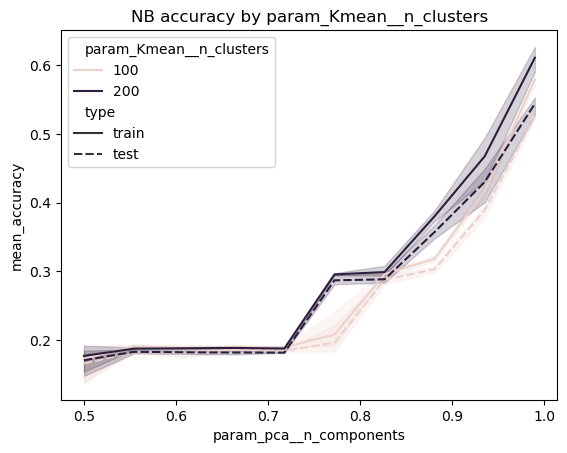

f1_weighted
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_Kmean__n_clusters', 'param_pca__n_components', 'param_scaler',
       'params', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy',
       'split1_train_accuracy', 'split2_train_accuracy',
       'split3_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy',
       'split0_test_f1_weighted', 'split1_test_f1_weighted',
       'split2_test_f1_weighted', 'split3_test_f1_weighted',
       'mean_test_f1_weighted', 'std_test_f1_weighted',
       'rank_test_f1_weighted', 'split0_train_f1_weighted',
       'split1_train_f1_weighted', 'split2_train_f1_weighted',
       'split3_train_f1_weighted', 'mean_train_f1_weighted',
       'std_train_f1_weighted', 'split0_test_roc_auc_ovr',
       'split1_test_roc_auc_ovr', 'split2_test_roc_auc_ovr',
 

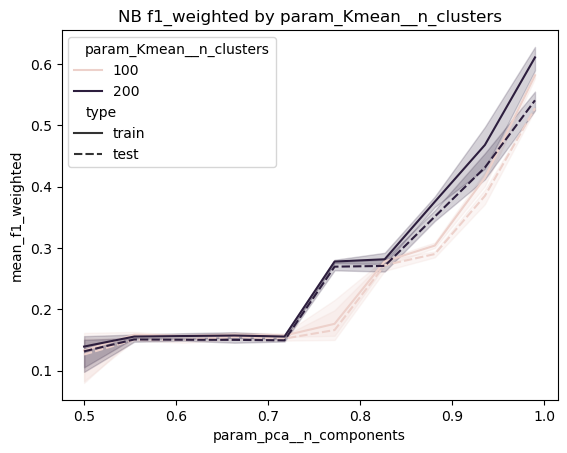

roc_auc_ovr
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_Kmean__n_clusters', 'param_pca__n_components', 'param_scaler',
       'params', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy',
       'split1_train_accuracy', 'split2_train_accuracy',
       'split3_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy',
       'split0_test_f1_weighted', 'split1_test_f1_weighted',
       'split2_test_f1_weighted', 'split3_test_f1_weighted',
       'mean_test_f1_weighted', 'std_test_f1_weighted',
       'rank_test_f1_weighted', 'split0_train_f1_weighted',
       'split1_train_f1_weighted', 'split2_train_f1_weighted',
       'split3_train_f1_weighted', 'mean_train_f1_weighted',
       'std_train_f1_weighted', 'split0_test_roc_auc_ovr',
       'split1_test_roc_auc_ovr', 'split2_test_roc_auc_ovr',
 

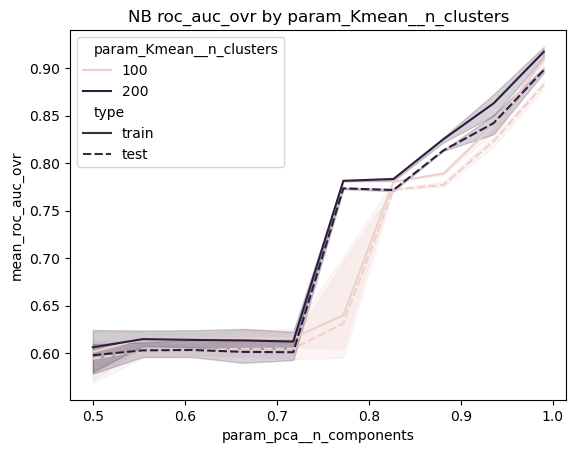

accuracy
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_Kmean__n_clusters', 'param_pca__n_components', 'param_scaler',
       'params', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy',
       'split1_train_accuracy', 'split2_train_accuracy',
       'split3_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy',
       'split0_test_f1_weighted', 'split1_test_f1_weighted',
       'split2_test_f1_weighted', 'split3_test_f1_weighted',
       'mean_test_f1_weighted', 'std_test_f1_weighted',
       'rank_test_f1_weighted', 'split0_train_f1_weighted',
       'split1_train_f1_weighted', 'split2_train_f1_weighted',
       'split3_train_f1_weighted', 'mean_train_f1_weighted',
       'std_train_f1_weighted', 'split0_test_roc_auc_ovr',
       'split1_test_roc_auc_ovr', 'split2_test_roc_auc_ovr',
    

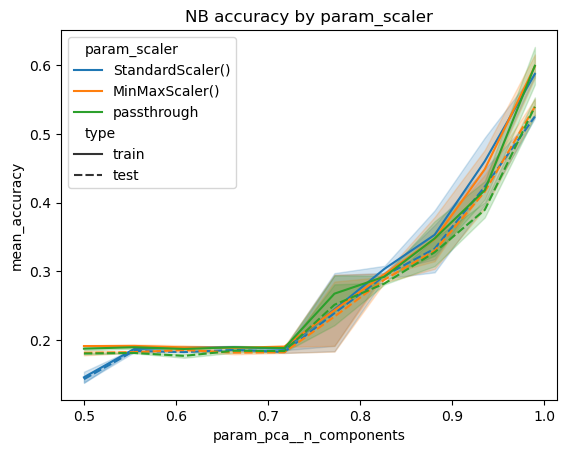

f1_weighted
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_Kmean__n_clusters', 'param_pca__n_components', 'param_scaler',
       'params', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy',
       'split1_train_accuracy', 'split2_train_accuracy',
       'split3_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy',
       'split0_test_f1_weighted', 'split1_test_f1_weighted',
       'split2_test_f1_weighted', 'split3_test_f1_weighted',
       'mean_test_f1_weighted', 'std_test_f1_weighted',
       'rank_test_f1_weighted', 'split0_train_f1_weighted',
       'split1_train_f1_weighted', 'split2_train_f1_weighted',
       'split3_train_f1_weighted', 'mean_train_f1_weighted',
       'std_train_f1_weighted', 'split0_test_roc_auc_ovr',
       'split1_test_roc_auc_ovr', 'split2_test_roc_auc_ovr',
 

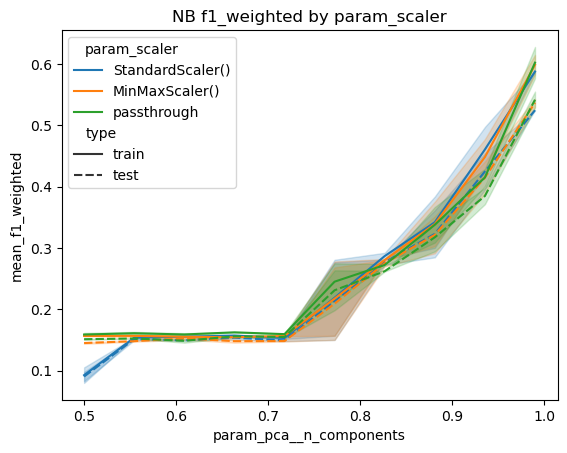

roc_auc_ovr
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_Kmean__n_clusters', 'param_pca__n_components', 'param_scaler',
       'params', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy',
       'split1_train_accuracy', 'split2_train_accuracy',
       'split3_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy',
       'split0_test_f1_weighted', 'split1_test_f1_weighted',
       'split2_test_f1_weighted', 'split3_test_f1_weighted',
       'mean_test_f1_weighted', 'std_test_f1_weighted',
       'rank_test_f1_weighted', 'split0_train_f1_weighted',
       'split1_train_f1_weighted', 'split2_train_f1_weighted',
       'split3_train_f1_weighted', 'mean_train_f1_weighted',
       'std_train_f1_weighted', 'split0_test_roc_auc_ovr',
       'split1_test_roc_auc_ovr', 'split2_test_roc_auc_ovr',
 

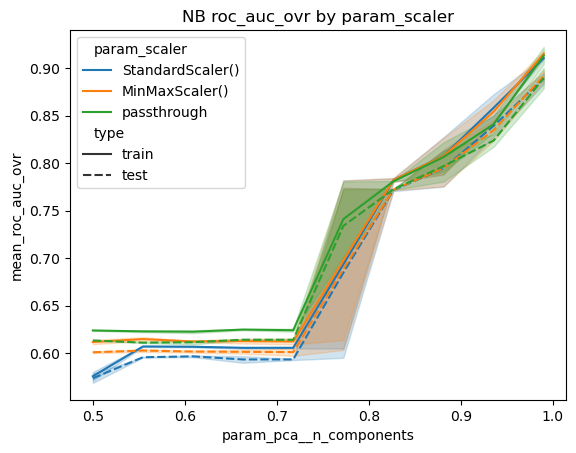

results/nb


/tmp/ipykernel_11572/2940774545.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_res['best_final_test_accuracy'] = accuracy_score(le.transform(y_test),y_pred.argmax(axis=1))
/tmp/ipykernel_11572/2940774545.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_res['best_final_test_accuracy'] = accuracy_score(le.transform(y_test),y_pred.argmax(axis=1))
/tmp/ipykernel_11572/2940774545.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [ ]:
#temp = analyze('nb','param_pca__n_components', x_test, y_test, save=save, out_dir=res_dir)

In [16]:
eh = models[0]

In [24]:
eh.named_steps['pca']

PCA(n_components=0.95)